In [ ]:
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!python -m pip install nemo_toolkit[all]
import glob
import os
import subprocess
import tarfile
import wget
import nemo
import nemo.collections.asr as nemo_asr
import json
import pytorch_lightning as pl
from omegaconf import DictConfig

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=93aca268e048b2c98050109ab9514b9115dff3253c7362e64a2f0aa01f8d7649
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-

[NeMo W 2022-05-11 20:33:11 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



### попытка №2

In [ ]:
%%writefile get_commonvoice_data.py
# Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Copyright (c) 2020, SeanNaren.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# To convert mp3 files to wav using sox, you must have installed sox with mp3 support
# For example sudo apt-get install libsox-fmt-mp3
import argparse
import csv
import json
import logging
import multiprocessing
import os
import subprocess
import sys
import tarfile
from multiprocessing.pool import ThreadPool
from pathlib import Path
from typing import List

import sox
from sox import Transformer
from tqdm import tqdm

parser = argparse.ArgumentParser(description='Downloads and processes Mozilla Common Voice dataset.')
parser.add_argument("--data_root", default='CommonVoice_dataset/', type=str, help="Directory to store the dataset.")
parser.add_argument('--manifest_dir', default='./', type=str, help='Output directory for manifests')
parser.add_argument("--num_workers", default=multiprocessing.cpu_count(), type=int, help="Workers to process dataset.")
parser.add_argument('--sample_rate', default=16000, type=int, help='Sample rate')
parser.add_argument('--n_channels', default=1, type=int, help='Number of channels for output wav files')
parser.add_argument("--log", dest="log", action="store_true", default=False)
parser.add_argument("--cleanup", dest="cleanup", action="store_true", default=False)
parser.add_argument(
    '--files_to_process',
    nargs='+',
    default=['test.tsv', 'dev.tsv', 'train.tsv'],
    type=str,
    help='list of *.csv file names to process',
)
parser.add_argument(
    '--version',
    default='cv-corpus-5.1-2020-06-22',
    type=str,
    help='Version of the dataset (obtainable via https://commonvoice.mozilla.org/en/datasets',
)
parser.add_argument(
    '--language',
    default='en',
    type=str,
    help='Which language to download.(default english,'
    'check https://commonvoice.mozilla.org/en/datasets for more language codes',
)
args = parser.parse_args()
COMMON_VOICE_URL = (
    f"https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/"
    "{}/{}.tar.gz".format(args.version, args.language)
)


def create_manifest(data: List[tuple], output_name: str, manifest_path: str):
    output_file = Path(manifest_path) / output_name
    output_file.parent.mkdir(exist_ok=True, parents=True)

    with output_file.open(mode='w') as f:
        for wav_path, duration, text in tqdm(data, total=len(data)):
            f.write(
                json.dumps({'audio_filepath': os.path.abspath(wav_path), "duration": duration, 'text': text}) + '\n'
            )


def process_files(csv_file, data_root, num_workers):
    """ Read *.csv file description, convert mp3 to wav, process text.
        Save results to data_root.

    Args:
        csv_file: str, path to *.csv file with data description, usually start from 'cv-'
        data_root: str, path to dir to save results; wav/ dir will be created
    """
    wav_dir = os.path.join(data_root, 'wav/')
    os.makedirs(wav_dir, exist_ok=True)
    audio_clips_path = os.path.dirname(csv_file) + '/clips/'

    def process(x):
        file_path, text = x
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        text = text.lower().strip()
        audio_path = os.path.join(audio_clips_path, file_path)
        output_wav_path = os.path.join(wav_dir, file_name + '.wav')

        if not os.path.exists(output_wav_path):
            tfm = Transformer()
            tfm.rate(samplerate=args.sample_rate)
            tfm.channels(n_channels=args.n_channels)
            tfm.build(input_filepath=audio_path, output_filepath=output_wav_path)

        duration = sox.file_info.duration(output_wav_path)
        return output_wav_path, duration, text

    logging.info('Converting mp3 to wav for {}.'.format(csv_file))
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        next(reader, None)  # skip the headers
        data = [(row['path'], row['sentence']) for row in reader]
        with ThreadPool(num_workers) as pool:
            data = list(tqdm(pool.imap(process, data), total=len(data)))
    return data


def main():
    if args.log:
        logging.basicConfig(level=logging.INFO)

    data_root = args.data_root
    os.makedirs(data_root, exist_ok=True)

    target_unpacked_dir = os.path.join(data_root, "CV_unpacked")

    if os.path.exists(target_unpacked_dir):
        logging.info('Find existing folder {}'.format(target_unpacked_dir))
    else:
        logging.info("Could not find Common Voice, Downloading corpus...")

        commands = [
            'wget',
            '--user-agent',
            '"Mozilla/5.0 (Windows NT 10.0; WOW64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"',
            '-P',
            data_root,
            f'{COMMON_VOICE_URL}',
        ]
        commands = " ".join(commands)
        subprocess.run(commands, shell=True, stderr=sys.stderr, stdout=sys.stdout, capture_output=False)
        filename = f"{args.language}.tar.gz"
        target_file = os.path.join(data_root, os.path.basename(filename))

        os.makedirs(target_unpacked_dir, exist_ok=True)
        logging.info("Unpacking corpus to {} ...".format(target_unpacked_dir))
        tar = tarfile.open(target_file)
        tar.extractall(target_unpacked_dir)
        tar.close()
        if args.cleanup:
            logging.info("removing tar archive to save space")
            os.remove(target_file)

    folder_path = os.path.join(target_unpacked_dir, args.version + f'/{args.language}/')

    for csv_file in args.files_to_process:
        data = process_files(
            csv_file=os.path.join(folder_path, csv_file),
            data_root=os.path.join(data_root, os.path.splitext(csv_file)[0]),
            num_workers=args.num_workers,
        )
        logging.info('Creating manifests...')
        create_manifest(
            data=data,
            output_name=f'commonvoice_{os.path.splitext(csv_file)[0]}_manifest.json',
            manifest_path=args.manifest_dir,
        )


if __name__ == "__main__":
    main()


Writing get_commonvoice_data.py


In [ ]:
!apt install sox libsox-fmt-mp3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libid3tag0 libmad0
The following NEW packages will be installed:
  libid3tag0 libmad0 libsox-fmt-mp3
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 112 kB of archives.
After this operation, 370 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libid3tag0 amd64 0.15.1b-13 [31.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libmad0 amd64 0.15.1b-9ubuntu18.04.1 [64.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libsox-fmt-mp3 amd64 14.4.2-3ubuntu0.18.04.1 [15.9 kB]
Fetched 112 kB in 1s

In [ ]:
!python3 get_commonvoice_data.py --data_root commonvoice --manifest_dir cv_manifests --language pl

--2022-05-11 20:33:19--  https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/pl.tar.gz
Resolving voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)... 52.92.192.17
Connecting to voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)|52.92.192.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3262705972 (3.0G) [application/octet-stream]
Saving to: ‘commonvoice/pl.tar.gz’

pl.tar.gz           100%[===================>]   3.04G  17.5MB/s    in 3m 3s   

2022-05-11 20:36:22 (17.0 MB/s) - ‘commonvoice/pl.tar.gz’ saved [3262705972/3262705972]

100% 4457/4457 [01:55<00:00, 38.47it/s]
100% 4457/4457 [00:00<00:00, 93462.59it/s]
100% 4457/4457 [01:56<00:00, 38.40it/s]
100% 4457/4457 [00:00<00:00, 105728.19it/s

## скачивание датасета НИСа

In [ ]:
data_dir = '/content'

def load(golos_url, fname):
  if not os.path.exists(os.path.join(data_dir, fname)):
      golos_path = wget.download(golos_url, os.path.join(data_dir, fname))
      print(f"Dataset downloaded at: {golos_path}")
  else:
      print("Tarfile already exists.")
      golos_path = os.path.join(data_dir, fname)
  return golos_path

golos_path = load("https://sc.link/Kqr", "test.tar")

if not os.path.exists(os.path.join(data_dir, '/test/')):
    tar = tarfile.open(golos_path)
    tar.extractall(path=data_dir)

import shutil

#shutil.rmtree('/content/sample_data')

print('done')

Tarfile already exists.


KeyboardInterrupt: ignored

## строим манифесты

In [ ]:
def build_manifest(manifest_rel, manifest_abs):
    manifest_path = os.path.split(os.path.abspath(manifest_rel))[0]
    with open(manifest_rel, 'r') as fin:
        with open(manifest_abs, 'w') as fout:
            for line in fin:
                metadata = json.loads(line)
                res_path = os.path.join(manifest_path, metadata["audio_filepath"])
                if os.path.exists(res_path):
                    metadata["audio_filepath"]=res_path
                    json.dump(metadata, fout)
                    fout.write('\n')

### Манифест для данных НИСа

In [ ]:

print("******")
test_rel = os.path.join(data_dir, 'test/farfield/manifest.jsonl')
test_abs = os.path.join(data_dir, 'test/farfield/farfield.jsonl')
if not os.path.isfile(test_abs):
  build_manifest(test_rel, test_abs)
test_manifest = test_abs
print("test_manifest", test_manifest)

train_rel = os.path.join(data_dir, 'test/crowd/manifest.jsonl')
train_abs = os.path.join(data_dir, 'test/crowd/crowd.jsonl')
if not os.path.isfile(train_abs):
  build_manifest(train_rel, train_abs)
train_manifest = train_abs
print("train_manifest", train_manifest)


test_abs_nis = test_abs
test_rel_nis = test_rel
test_manifest_nis = test_manifest
train_abs_nis = train_abs
train_rel_nis = train_rel
train_manifest_nis = train_manifest

******


NameError: ignored

### Манифест для данных CommonVoice

In [ ]:
#data_dir = '/content/drive/MyDrive/курсовая_работа_2_0/'
data_dir = '/content/cv_manifests'
from google.colab import drive
drive.mount('/content/drive/')

print("******")
test_rel = f"{data_dir}/commonvoice_test_manifest_rel.json"
test_abs = f"{data_dir}/commonvoice_test_manifest.json"
#test_abs = f"{data_dir}/commonvoice_test_manifest_rel.json"
if not os.path.isfile(test_abs): build_manifest(test_rel, test_abs)
test_manifest = test_abs
print("test_manifest", test_manifest)

train_rel = f"{data_dir}/commonvoice_train_manifest_rel.json"
train_abs = f"{data_dir}/commonvoice_train_manifest.json"
#train_abs = f"{data_dir}/commonvoice_train_manifest_rel.json"
if not os.path.isfile(train_abs): build_manifest(train_rel, train_abs)
train_manifest = train_abs
print("train_manifest", train_manifest)

test_abs_cv = test_abs
test_rel_cv = test_rel
test_manifest_cv = test_manifest
train_abs_cv = train_abs
train_rel_cv = train_rel
train_manifest_cv = train_manifest

Mounted at /content/drive/
******
test_manifest /content/cv_manifests/commonvoice_test_manifest.json
train_manifest /content/cv_manifests/commonvoice_train_manifest.json


##Создание файла

In [ ]:
#trainer = pl.Trainer(strategy='dp', gpus=1, max_epochs=10, precision=16)
trainer = pl.Trainer(gpus=1, max_epochs=10, precision=16)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
#здесь добавь создание файла с нуля - авось, поможет при сравнении моделей разных? Не знаю, ищу что-то, что я бы мог проверить в курсаче
data_dir_2 = '/content/drive/MyDrive/курсовая_работа_2_0/'
#asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir_2, "QuartzNet15x5_golos.nemo"), trainer=trainer)
asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_pl_quartznet15x5", trainer=trainer)
params_model = asr_model._cfg
#params_model['train_ds']['parser']='base'
#params_model['validation_ds']['parser']='base'
#params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath'] = train_manifest
params_model['train_ds']['batch_size']=40
params_model['validation_ds']['manifest_filepath'] = test_manifest
params_model['validation_ds']['batch_size']=40
#params_model['test_ds']['manifest_filepath'] = test_manifest
#params_model['test_ds']['batch_size']=40
params_model['optim']['lr'] = 0.005
#params_model['repeat'] = 3

[NeMo I 2022-05-05 09:43:11 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_pl_quartznet15x5/versions/1.0.0rc1/files/stt_pl_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/stt_pl_quartznet15x5/a0688bd9116271719abfca130a32ac92/stt_pl_quartznet15x5.nemo
[NeMo I 2022-05-05 09:43:15 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-05 09:43:16 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /raid/noneval.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - ą
    - b
    - c
    - ć
    - d
    - e
    - ę
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - ł
    - m
    - 'n'
    - ń
    - o
    - ó
    - p
    - r
    - s
    - ś
    - t
    - u
    - w
    - 'y'
    - z
    - ź
    - ż
    batch_size: 16
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 8
    pin_memory: true
    
[NeMo W 2022-05-05 09:43:16 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data l

[NeMo I 2022-05-05 09:43:16 features:259] PADDING: 16
[NeMo I 2022-05-05 09:43:16 features:276] STFT using torch
[NeMo I 2022-05-05 09:43:29 save_restore_connector:209] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/stt_pl_quartznet15x5/a0688bd9116271719abfca130a32ac92/stt_pl_quartznet15x5.nemo.


In [ ]:
#asr_model.setup_multiple_test_data(params_model['test_ds'])
asr_model.setup_training_data(params_model['train_ds'])

[NeMo I 2022-05-05 09:43:29 audio_to_text_dataset:42] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-05-05 09:43:29 audio_to_text_dataset:42] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-05-05 09:43:29 collections:186] Dataset loaded with 6089 files totalling 7.72 hours
[NeMo I 2022-05-05 09:43:29 collections:187] 0 files were filtered totalling 0.00 hours


[NeMo W 2022-05-05 09:43:29 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


In [ ]:
trainer.fit(asr_model)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2022-05-05 09:43:36 modelPT:497] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7fafa16e0d50>. We recommend to use 'ddp' instead.


[NeMo I 2022-05-05 09:43:36 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.005
        weight_decay: 0.001
    )
[NeMo I 2022-05-05 09:43:36 lr_scheduler:837] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fafa172dfd0>" 
    will be used during training (effective maximum steps = 1530) - 
    Parameters : 
    (warmup_steps: 500
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1530
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
37.859    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2022-05-05 09:43:36 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:378: UserWarning: One of given dataloaders is None and it will be skipped.
      rank_zero_warn("One of given dataloaders is None and it will be skipped.")
    


Training: 0it [00:00, ?it/s]

[NeMo W 2022-05-05 09:43:36 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2022-05-05 09:43:46 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-ad

In [ ]:
# files = [data_dir + '/test/common_voice_ru_20111336.mp3']
files = ["/content/commonvoice/test/wav/common_voice_ru_20111336.wav"]

Предобученная модель (golos)

In [ ]:
print(asr_model.transcribe(paths2audio_files=files,
                                 batch_size=4))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['в декабре мы представим более комплексной план по реализации проекта поласти и сохранения наследия']


Предобученная модель (стандартная)

In [ ]:
print(asr_model.transcribe(paths2audio_files=files,
                                 batch_size=4))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['в декабриму предстоем более комплексный пмант реализации проекта в области сохранениям наследия']


In [ ]:
asr_model.save_to('/content/drive/MyDrive/курсовая_работа_2_0/finally_good_model_commonvoice_stt_polish')

In [ ]:
our_asr_model = nemo_asr.models.EncDecCTCModel.restore_from('/content/drive/MyDrive/курсовая_работа_2_0/first_asr_model_continued_5')

params_model = our_asr_model._cfg
# !!! вот тут на самом деле используется не манифест из ячейки "строим манифесты"
# а тот который скачался в самом начале тетрадки
params_model['test_ds']['manifest_filepath']='/content/cv_manifests/commonvoice_test_manifest.json'
params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath']='/content/cv_manifests/commonvoice_train_manifest.json'
params_model['train_ds']['learning_rate']=0.001
params_model['train_ds']['batch_size']=32
params_model['validation_ds']['manifest_filepath'] = '/content/cv_manifests/commonvoice_test_manifest.json'

our_asr_model.setup_multiple_test_data(params_model['test_ds'])

our_asr_model.cuda()

for test_batch in our_asr_model.test_dataloader():
        print(test_batch); break

In [ ]:
our_asr_model.setup_multiple_test_data(params_model['test_ds'])
our_asr_model.setup_training_data(params_model['train_ds'])

[NeMo I 2022-04-11 14:09:48 collections:173] Dataset loaded with 7306 files totalling 12.56 hours
[NeMo I 2022-04-11 14:09:48 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-11 14:09:49 collections:173] Dataset loaded with 5000 files totalling 7.79 hours
[NeMo I 2022-04-11 14:09:49 collections:174] 0 files were filtered totalling 0.00 hours


[NeMo W 2022-04-11 14:09:49 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


In [ ]:
trainer.fit(our_asr_model)

[NeMo W 2022-04-11 15:43:33 modelPT:475] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-04-11 15:43:33 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.005
        weight_decay: 0.001
    )


[NeMo W 2022-04-11 15:43:33 lr_scheduler:817] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.718    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-11 15:43:34 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:489: UserWarning: One of given dataloaders is None and it will be skipped.
      rank_zero_warn("One of given dataloaders is None and it will be skipped.")
    


Training: 0it [00:00, ?it/s]

[NeMo W 2022-04-11 15:43:34 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


In [ ]:
our_model_cv = nemo_asr.models.EncDecCTCModel.restore_from('/content/drive/MyDrive/курсовая_работа_2_0/our_asr_model_mod (1)')

params_model = our_model_cv._cfg
params_model['test_ds']['parser']='base'
our_model_cv.setup_multiple_test_data(params_model['test_ds'])

our_model_cv.cuda()

wer_nums = []
wer_denoms = []

for test_batch in our_model_cv.test_dataloader():
        print(test_batch); break

[NeMo W 2022-04-07 09:05:49 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/test/crowd/crowd.jsonl
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 16
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: base
    
[NeMo W 2022-04-07 09:05:49 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and p

[NeMo I 2022-04-07 09:05:49 features:255] PADDING: 16
[NeMo I 2022-04-07 09:05:49 features:272] STFT using torch
[NeMo I 2022-04-07 09:05:50 save_restore_connector:157] Model EncDecCTCModel was successfully restored from /content/drive/MyDrive/курсовая_работа_2_0/our_asr_model_mod (1).
[NeMo I 2022-04-07 09:05:50 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2022-04-07 09:05:50 collections:174] 0 files were filtered totalling 0.00 hours
(tensor([[-6.7535e-06,  3.2311e-06,  1.4836e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.5588e-04,  2.3135e-04,  2.2682e-04,  ...,  2.4838e-04,
          1.7601e-04,  2.7571e-04],
        [-4.3742e-05, -4.5498e-05, -5.1221e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-4.9123e-04, -4.1996e-04, -3.9498e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.9418e-04,  1.2496e-04,  1.0773e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],

## Все остальное

In [ ]:
asr_model = nemo_asr.models.EncDecCTCModel.restore_from('finally_good_model_commonvoice')
params_model = asr_model._cfg
params_model['test_ds']['parser']='base'
asr_model.setup_multiple_test_data(params_model['test_ds'])

[NeMo W 2022-05-02 10:52:32 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/cv_manifests/commonvoice_train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 40
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: base
    
[NeMo W 2022-05-02 10:52:32 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validati

[NeMo I 2022-05-02 10:52:32 features:259] PADDING: 16
[NeMo I 2022-05-02 10:52:32 features:276] STFT using torch
[NeMo I 2022-05-02 10:52:33 save_restore_connector:209] Model EncDecCTCModel was successfully restored from /content/finally_good_model_commonvoice.
[NeMo I 2022-05-02 10:52:33 collections:186] Dataset loaded with 7306 files totalling 12.56 hours
[NeMo I 2022-05-02 10:52:33 collections:187] 0 files were filtered totalling 0.00 hours


In [ ]:
asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# # Loop over all test batches.
# # Iterating over the model's `test_dataloader` will give us:
# # (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# # See the AudioToCharDataset for more details.
for test_batch in asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = asr_model._wer.compute()
        asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

#         # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

RuntimeError: ignored

In [ ]:
del 

In [ ]:
import pprint
pprint.pprint(locals())

{'DictConfig': <class 'omegaconf.dictconfig.DictConfig'>,
 'In': ['',
        'print(torch.cuda.memory_summary(device=None, abbreviated=False))',
        'import gc\ngc.collect()\nimport torch\ntorch.cuda.empty_cache()',
        'print(torch.cuda.memory_summary(device=None, abbreviated=False))',
        "get_ipython().system('pip install wget')\n"
        "get_ipython().system('apt-get install sox libsndfile1 ffmpeg')\n"
        "get_ipython().system('pip install unidecode')\n"
        "get_ipython().system('python -m pip install nemo_toolkit[all]')\n"
        'import glob\n'
        'import os\n'
        'import subprocess\n'
        'import tarfile\n'
        'import wget\n'
        'import nemo\n'
        'import nemo.collections.asr as nemo_asr\n'
        'import json\n'
        'import pytorch_lightning as pl\n'
        'from omegaconf import DictConfig',
        'asr_model = '
        "nemo_asr.models.EncDecCTCModel.restore_from('finally_good_model_commonvoice')\n"
        'param

In [ ]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   74360 KB |  148719 KB |  148720 KB |   74359 KB |
|       from large pool |    2048 KB |    4096 KB |    4096 KB |    2048 KB |
|       from small pool |   72312 KB |  144623 KB |  144624 KB |   72311 KB |
|---------------------------------------------------------------------------|
| Active memory         |   74360 KB |  148719 KB |  148720 KB |   74359 KB |
|       from large pool |    2048 KB |    4096 KB |    4096 KB |

In [ ]:
# del log_probs, targets, targets_lengths, encoded_len, greedy_predictions
#del targets, targets_lengths
for i in our_asr_model.test_dataloader():
  j_list = [j.cuda() for j in i]
  targets = j_list[2]
  targets_lengths = j_list[3]
  log_probs, encoded_len, greedy_predictions = our_asr_model(
            input_signal=j_list[0], input_signal_length=j_list[1]
        )
  print(f'Targets: {targets}\nTargets_lengths: {targets_lengths}\nPredictions: {greedy_predictions}')
  break

Targets: tensor([[16,  1, 12,  ...,  0,  0,  0],
        [20,  0, 13,  ...,  0,  0,  0],
        [11,  0, 18,  ...,  0,  0,  0],
        ...,
        [ 3,  6,  5,  ...,  0,  0,  0],
        [13,  9,  4,  ...,  0,  0,  0],
        [ 4, 15, 18,  ...,  0,  0,  0]], device='cuda:0')
Targets_lengths: tensor([103,  66,  42,  56,  77,   4,  49,  85,  85,  91,  44,  26, 112,  59,
         50,  77], device='cuda:0')
Predictions: tensor([[33, 33, 33,  ..., 33, 33, 33],
        [33, 33, 33,  ..., 33, 33, 33],
        [33, 33, 33,  ..., 33, 33, 33],
        ...,
        [33, 33, 33,  ..., 33, 33, 33],
        [33, 33, 33,  ..., 33, 33, 33],
        [33, 33, 33,  ..., 33, 33, 33]], device='cuda:0')


In [ ]:
for i in our_asr_model.test_dataloader():
  j_list = [j.cuda() for j in i]
  targets = j_list[2]
  targets_lengths = j_list[3]
  log_probs, encoded_len, greedy_predictions = our_asr_model(
            input_signal=j_list[0], input_signal_length=j_list[1]
        )
  print(f'Targets: {targets}\nTargets_lengths: {targets_lengths}\nPredictions: {greedy_predictions}')
  break

Targets: tensor([[16,  1, 12,  ...,  0,  0,  0],
        [20,  0, 13,  ...,  0,  0,  0],
        [11,  0, 18,  ...,  0,  0,  0],
        ...,
        [ 3,  6,  5,  ...,  0,  0,  0],
        [13,  9,  4,  ...,  0,  0,  0],
        [ 4, 15, 18,  ...,  0,  0,  0]], device='cuda:0')
Targets_lengths: tensor([103,  66,  42,  56,  77,   4,  49,  85,  85,  91,  44,  26, 112,  59,
         50,  77], device='cuda:0')
Predictions: tensor([[33, 33, 33,  ...,  7,  7,  7],
        [33, 33, 33,  ...,  7,  7,  7],
        [33, 33, 33,  ...,  7,  7,  7],
        ...,
        [33, 33, 33,  ...,  7,  7,  7],
        [33, 33, 33,  ..., 33,  7,  7],
        [33, 33, 33,  ...,  7,  7,  7]], device='cuda:0')


In [ ]:
for i in our_model_cv.test_dataloader():
  print(i)
  break

(tensor([[-6.7535e-06,  3.2311e-06,  1.4836e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.5588e-04,  2.3135e-04,  2.2682e-04,  ...,  2.4838e-04,
          1.7601e-04,  2.7571e-04],
        [-4.3742e-05, -4.5498e-05, -5.1221e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-4.9123e-04, -4.1996e-04, -3.9498e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.9418e-04,  1.2496e-04,  1.0773e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2806e-04,  1.5989e-04,  2.7509e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), tensor([27146, 50753, 24363, 49025, 37036, 20962, 30415, 29007, 31912, 23944,
        24788, 47983, 28203, 30183, 30001, 32409]), tensor([[ 5,  7, 15, 10,  0, 22,  3,  1, 19,  9, 19,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [18,  1, 12, 31, 19,  0,  3, 28,  8,

In [ ]:
print(i[0][0].tolist()[:100])

[-6.753460638719844e-06, 3.231054961361224e-06, 1.4835542060609441e-05, 1.535456976853311e-05, 2.3898371637187665e-07, -1.054106542142108e-05, -1.4837878552498296e-05, -1.613305175851565e-05, -1.4634951185144018e-05, -1.340892140433425e-05, -8.784754754742607e-06, -1.6175026757991873e-05, -3.6019282561028376e-06, 1.8583357814350165e-05, 4.42775126430206e-05, 5.151118239155039e-05, 4.5708813559031114e-05, 3.7363464798545465e-05, 2.724684600252658e-05, 3.119177199550904e-05, 1.0063432455353905e-05, -5.755399797635619e-06, -1.8281149095855653e-05, -1.2462159247661475e-05, -1.053737105394248e-05, -7.054522029648069e-06, -1.5887579138507135e-05, -1.4891766113578342e-05, 4.493358574109152e-08, 1.3794964615954086e-05, 2.0121189663768746e-05, 7.193699275376275e-06, -8.380835424759425e-06, -3.3668729884084314e-05, -6.025630500516854e-05, -6.136666343081743e-05, -6.371623749146238e-05, -6.107721128500998e-05, -5.383597090258263e-05, -5.740187771152705e-05, -7.707708573434502e-05, -8.473459456581

In [ ]:
print(len(i[0][0].tolist()))

50753


In [ ]:
for i in our_asr_model.test_dataloader():
  print(i)
  break

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0006, -0.0003,  0.0002],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([149376,  94848,  81792,  94080, 127872,  40320, 107136, 117120, 127104,
        140928,  72576,  64896, 131712,  71424, 160512, 145920]), tensor([[16,  1, 12,  ...,  0,  0,  0],
        [20,  0, 13,  ...,  0,  0,  0],
        [11,  0, 18,  ...,  0,  0,  0],
        ...,
        [ 3,  6,  5,  ...,  0,  0,  0],
        [13,  9,  4,  ...,  0,  0,  0],
        [ 4, 15, 18,  ...,  0,  0,  0]]), tensor([103,  66,  42,  56,  77,   4,  49,  85,  85,  91,  44,  26, 112,  59,
         50,  77]))


In [ ]:
print(i[0][0].tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
print(len(i[0][0].tolist()))

160512


In [ ]:
# files = [data_dir + '/test/common_voice_ru_20111336.mp3']
files = ["/content/commonvoice/test/wav/common_voice_ru_20111336.wav"]

In [ ]:
print(our_model_cv.transcribe(paths2audio_files=files,
                                 batch_size=4))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['гукронимгусан варко мовят ноторизаса какосисоноеилири']


In [ ]:
test_files = [f for f in os.listdir('/content/commonvoice/test/wav/')]
print(len(test_files))

7306


In [ ]:
our_model_cv = nemo_asr.models.EncDecCTCModel.restore_from('/content/drive/MyDrive/курсовая_работа_2_0/finally_good_model_commonvoice_stt_polish')

[NeMo W 2022-05-11 20:44:17 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/cv_manifests/commonvoice_train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - ą
    - b
    - c
    - ć
    - d
    - e
    - ę
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - ł
    - m
    - 'n'
    - ń
    - o
    - ó
    - p
    - r
    - s
    - ś
    - t
    - u
    - w
    - 'y'
    - z
    - ź
    - ż
    batch_size: 40
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 8
    pin_memory: true
    
[NeMo W 2022-05-11 20:44:17 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration 

[NeMo I 2022-05-11 20:44:17 features:259] PADDING: 16
[NeMo I 2022-05-11 20:44:17 features:276] STFT using torch
[NeMo I 2022-05-11 20:44:32 save_restore_connector:209] Model EncDecCTCModel was successfully restored from /content/drive/MyDrive/курсовая_работа_2_0/finally_good_model_commonvoice_stt_polish.


In [ ]:
!pip install Levenshtein
import Levenshtein
import copy
from collections import Counter
import string as s
import re


replace = Counter()
insert = Counter()
delete = Counter()

def levencrawling(decoded, true):
  levenshtein = Levenshtein.editops(decoded, true)
  deviation = 0
  addendum = copy.copy(decoded)
  for tup in levenshtein:
    if tup[0] == 'replace':
      string = f'{addendum[tup[1] + deviation]} вместо {true[tup[2]]}'
      replace[string] += 1
      addendum = list(addendum)
      addendum[tup[1] + deviation] = true[tup[2]]
      addendum = ''.join(addendum)
    elif tup[0] == 'insert':
      if tup[1] + deviation == len(addendum):
        #print('here i am')
        addendum = addendum + true[tup[2]]
        string = f'{true[tup[2]]} в конце предложения'
      else:
        string = f'{true[tup[2]]} перед {addendum[tup[1] + deviation]}'
      insert[string] += 1
      gundam = list(addendum)
      gundam.insert(tup[1] + deviation, true[tup[2]])
      addendum = ''.join(gundam)
      deviation += 1
    elif tup[0] == 'delete':
      string = f'удалить {addendum[tup[1] + deviation]}'
      delete[string] += 1
      gandum = list(addendum)
      gandum.pop(tup[1] + deviation)
      addendum = ''.join(gandum)
      deviation -= 1

     |████████████████████████████████| 258 kB 31.2 MB/s 


In [ ]:
!pip install jiwer
from jiwer import wer

     |████████████████████████████████| 50 kB 6.8 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=c4d9b3cf443f9da4f65aad843c0004b9671735334ad9ecee796096deba4fcdc4
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
with open('/content/cv_manifests/commonvoice_test_manifest.json') as file:
  true_texts = []
  audio_paths = []
  for line in file.readlines():
    dictionary = json.loads(line)
    true_texts.append(dictionary['text'])
    audio_paths.append(dictionary['audio_filepath'])
    #true_text = dictionary['text']
    #decoded_text = our_model_cv.transcribe(paths2audio_files=[dictionary['audio_filepath']], batch_size=4)
  decoded_texts = our_model_cv.transcribe(paths2audio_files=audio_paths, batch_size=4)
  print(len(decoded_texts))
  print(len(true_texts))
  for item in range(len(decoded_texts)):
    true_text = true_texts[item].translate(str.maketrans('', '', s.punctuation))
    levencrawling(decoded_texts[item], true_text)
  wers = []
  for text in range(len(true_texts)):
    wers.append(wer(true_texts[text], decoded_texts[text]))
  print(sum(wers) / len(wers))

Transcribing:   0%|          | 0/1115 [00:00<?, ?it/s]

4457
4457
0.46931384933965076


In [ ]:
print(len(decoded_texts))

4457


In [ ]:
print(insert)

Counter({'— перед  ': 213, '  перед n': 209, '  перед  ': 189, '  перед p': 173, '  перед c': 159, '  перед t': 148, '  перед s': 134, '  перед w': 130, '  перед o': 117, '— перед p': 114, '  перед j': 112, 'e перед  ': 107, '— перед n': 106, '  перед m': 102, '  перед d': 100, '  перед z': 100, '… в конце предложения': 95, '— перед c': 86, '  перед a': 81, '— перед t': 76, 'm перед  ': 74, '  перед i': 73, '  перед r': 73, '— перед o': 72, '  перед k': 64, '— перед w': 64, '  перед b': 60, '— перед z': 58, 'j перед  ': 58, '— перед j': 58, 'c перед  ': 58, 'h перед  ': 52, '— перед a': 51, '  перед l': 50, 'w перед s': 48, 'ł перед  ': 47, 'i перед e': 46, 'e перед y': 46, '— перед m': 44, '— перед s': 43, 'n перед i': 42, 'a перед o': 41, 'y перед  ': 38, 'i перед y': 37, 'i перед  ': 36, '  перед g': 36, 'a перед  ': 36, '— перед d': 34, '  перед e': 33, 'o перед a': 32, 'w перед  ': 32, '… перед  ': 32, '  перед u': 30, 'o перед  ': 30, '” перед  ': 29, 'k перед  ': 28, 'z перед  '

In [ ]:
print(len(insert))

841


Частые ошибки с парсингом слов - много ошибок со "сьеданием" гласных

In [ ]:
print(dict(insert))

{'— перед t': 76, '  перед t': 148, 'd перед z': 21, 'a перед c': 5, 'l перед c': 3, 'e перед c': 10, '  перед c': 159, 'o перед c': 8, 'n перед c': 3, 'w перед c': 19, 'a перед h': 2, 'l перед h': 2, 'e перед h': 1, '  перед h': 22, 'i перед h': 3, 'n перед h': 2, 'z перед i': 24, 'e перед i': 11, 'j перед i': 10, '  перед i': 73, 'n перед i': 42, 'm перед h': 3, 'y перед h': 1, 'ś перед h': 1, '  перед j': 112, 'm перед  ': 74, 's перед  ': 15, 't перед  ': 27, 'r перед a': 12, '— перед c': 86, '  перед d': 100, '— перед p': 114, '  перед p': 173, 'i перед y': 37, 'a перед y': 4, 'r перед z': 9, 'e перед  ': 107, 'p перед g': 2, '— перед  ': 213, 'd перед  ': 22, '— перед o': 72, '  перед o': 117, 'p перед o': 21, 'i перед d': 11, 'e перед d': 14, 'ł перед e': 4, 'a перед e': 27, '  перед e': 33, '— перед z': 58, '  перед z': 100, '  перед  ': 189, 'o перед a': 32, '  перед l': 50, 'r перед t': 12, 'y перед g': 6, 'm перед n': 23, 'o перед p': 13, '  перед k': 64, 'u перед o': 10, 'j

In [ ]:
print(replace)

Counter({'y вместо e': 211, 'e вместо a': 173, 'o вместо a': 171, 'a вместо o': 136, 'e вместо y': 123, 'a вместо e': 105, 'd вместо t': 77, 'u вместо o': 69, 'o вместо u': 66, 'n вместо m': 59, 'e вместо ę': 57, 'm вместо n': 57, 'c вместо s': 49, 'l вместо n': 48, 't вместо d': 45, 'j вместо i': 43, 'l вместо r': 43, 'u вместо ó': 43, 'z вместо s': 43, 'ż вместо z': 42, 'e вместо o': 41, 's вместо z': 40, 'y вместо ę': 39, 'o вместо e': 39, 'ę вместо a': 37, 'b вместо w': 37, 'o вместо  ': 37, 'w вместо b': 35, 'a вместо ę': 35, 'ę вместо e': 35, 'p вместо b': 34, 'i вместо y': 34, 'p вместо t': 34, 's вместо  ': 34, 'y вместо o': 33, 'o вместо ą': 33, 'e вместо  ': 32, 'k вместо g': 32, 'z вместо i': 32, 'ą вместо o': 32, 'ę вместо ą': 32, 'i вместо j': 31, 'c вместо t': 29, 'g вместо k': 29, 'a вместо ą': 28, 'p вместо w': 28, 'ą вместо ę': 28, 'ł вместо w': 27, 't вместо c': 27, 'b вместо p': 26, 'i вместо e': 26, 'a вместо  ': 25, 'd вместо c': 23, 'u вместо e': 23, 's вместо c':

In [ ]:
print(len(replace))

823


важные штуки:
1. Р и Л - дентальные/альвеолярные (в столбце)
2. Т и С - такие же (тоже в столбце, то есть шансов того, что Р и Л - ошибка, становится меньше)
3. Н и Д - такие же (уже очень похоже на классный вывод - хотя странно, что Д)
4. Проблема с В - как будто модель не хочет ставить В в словах, потому что самые разные буквы заменяются на В (даже гласные)
5. Т и Ч - ну тут уже более логично - хотя тоже дентальные/альвеолярные
6. Ч и С - аффриката и фрикативный, вывод, не выходящий за рамки
7. Т и Л - вот не знаю, не могу особо понять, как можно перепутать Т и Л
8. Д и Л - см. 7 пункт

In [ ]:
print(dict(replace))

{'h вместо a': 2, 'o вместо ł': 11, 'p вместо b': 34, 'n вместо ń': 6, 'i вместо  ': 17, 'a вместо o': 136, 'ż вместо z': 42, 'm вместо d': 6, 'p вместо k': 21, 'y вместо ę': 39, 'o вместо u': 66, 'y вместо j': 17, 'w вместо ą': 2, 'y вместо  ': 17, 'w вместо b': 35, 'y вместо o': 33, 'e вместо a': 173, 'g вместо r': 8, 'o вместо h': 3, '  вместо c': 11, 'j вместо ę': 2, 'e вместо  ': 32, 'l вместо w': 17, 'g вместо d': 17, 'w вместо z': 20, 'c вместо s': 49, 'z вместо ź': 2, 'k вместо l': 1, 'g вместо ł': 3, 'r вместо k': 2, 'u вместо o': 69, 'i вместо d': 4, 'n вместо z': 17, 'o вместо a': 171, 'a вместо e': 105, 'z вместо l': 9, 'n вместо y': 4, 'j вместо i': 43, 'i вместо y': 34, 'l вместо r': 43, 'n вместо m': 59, 'e вместо ę': 57, 'j вместо o': 2, 'y вместо e': 211, '  вместо s': 17, 'z вместо t': 15, 't вместо d': 45, 'ł вместо m': 22, 'o вместо p': 4, 'ł вместо w': 27, 'm вместо w': 15, 'u вместо i': 7, 'p вместо f': 16, 't вместо s': 4, 'c вместо  ': 20, 'h вместо s': 4, 'd вм

In [ ]:
print(delete)

Counter({'удалить  ': 513, 'удалить z': 145, 'удалить i': 122, 'удалить e': 110, 'удалить ł': 77, 'удалить a': 71, 'удалить m': 71, 'удалить o': 69, 'удалить w': 60, 'удалить l': 44, 'удалить p': 43, 'удалить c': 43, 'удалить u': 42, 'удалить s': 42, 'удалить j': 41, 'удалить y': 39, 'удалить n': 38, 'удалить h': 37, 'удалить r': 34, 'удалить t': 33, 'удалить d': 32, 'удалить k': 30, 'удалить b': 21, 'удалить ś': 17, 'удалить ę': 16, 'удалить g': 13, 'удалить ć': 8, 'удалить ą': 8, 'удалить ó': 6, 'удалить ż': 5, 'удалить ń': 4, 'удалить ź': 2, 'удалить f': 2})


In [ ]:
print(len(delete))

33


Частые ошибки с парсингом слов - при этом очень мало ошибок с аффрикатами и мало ошибок с фрикативами (за исключением С)

In [ ]:
print(dict(delete))

{'удалить r': 34, 'удалить o': 69, 'удалить  ': 513, 'удалить p': 43, 'удалить a': 71, 'удалить e': 110, 'удалить ł': 77, 'удалить c': 43, 'удалить u': 42, 'удалить i': 122, 'удалить w': 60, 'удалить d': 32, 'удалить ż': 5, 'удалить y': 39, 'удалить t': 33, 'удалить h': 37, 'удалить m': 71, 'удалить l': 44, 'удалить g': 13, 'удалить z': 145, 'удалить ć': 8, 'удалить ó': 6, 'удалить b': 21, 'удалить s': 42, 'удалить j': 41, 'удалить k': 30, 'удалить n': 38, 'удалить ę': 16, 'удалить ś': 17, 'удалить ń': 4, 'удалить ą': 8, 'удалить ź': 2, 'удалить f': 2}


In [ ]:
our_model_cv = nemo_asr.models.EncDecCTCModel.restore_from('/content/finally_good_model_commonvoice')

[NeMo W 2022-05-02 20:55:24 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/cv_manifests/commonvoice_train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 40
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: base
    
[NeMo W 2022-05-02 20:55:24 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validati

[NeMo I 2022-05-02 20:55:24 features:259] PADDING: 16
[NeMo I 2022-05-02 20:55:24 features:276] STFT using torch
[NeMo I 2022-05-02 20:55:25 save_restore_connector:209] Model EncDecCTCModel was successfully restored from /content/finally_good_model_commonvoice.


In [ ]:
with open('/content/cv_manifests/commonvoice_test_manifest.json') as file:
  true_texts = []
  audio_paths = []
  for line in file.readlines():
    dictionary = json.loads(line)
    true_texts.append(dictionary['text'])
    audio_paths.append(dictionary['audio_filepath'])
    #true_text = dictionary['text']
    #decoded_text = our_model_cv.transcribe(paths2audio_files=[dictionary['audio_filepath']], batch_size=4)
  decoded_texts = our_model_cv.transcribe(paths2audio_files=audio_paths, batch_size=4)
  print(len(decoded_texts))
  print(len(true_texts))
  for item in range(len(decoded_texts)):
    true_text = true_texts[item].translate(str.maketrans('', '', s.punctuation))
    levencrawling(decoded_texts[item], true_text)
  wers = []
  for text in range(len(true_texts)):
    wers.append(wer(true_texts[text], decoded_texts[text]))
  print(sum(wers) / len(wers))

Transcribing:   0%|          | 0/1827 [00:00<?, ?it/s]

7306
7306
0.32247664755021643


In [ ]:
print(insert)

Counter({'  перед  ': 799, '  перед с': 350, 'и перед  ': 326, 'в перед  ': 302, 'е перед и': 300, '  перед н': 295, '— перед  ': 291, 'е перед  ': 238, 'о перед  ': 231, 'й перед  ': 230, 'о перед а': 220, '  перед п': 212, 'и перед е': 207, '  перед о': 204, 'а перед  ': 202, '  перед и': 201, 'ь перед  ': 199, 'т перед  ': 193, 'м перед  ': 180, 'а перед о': 178, '  перед в': 176, '  перед т': 173, 'в перед с': 170, '  перед е': 148, 'с перед  ': 147, '  перед д': 145, '  перед м': 143, 'я перед  ': 142, '  перед к': 141, 'ы перед  ': 133, 'в перед о': 125, '  перед р': 122, 'о перед р': 120, 'о перед ы': 116, 'е перед н': 116, 'х перед  ': 111, 'о перед с': 109, 'у перед  ': 109, '  перед л': 109, 'с перед т': 104, 'о перед у': 103, 'р перед о': 102, '  перед з': 102, 'н перед  ': 102, 'н перед н': 100, 'н перед о': 99, 'н перед е': 98, 'н перед и': 97, '  перед э': 95, '  перед б': 94, '  перед г': 94, '  перед а': 94, 'о перед н': 93, '– перед  ': 90, 'ы перед о': 90, 'и перед и'

In [ ]:
print(len(insert))

960


Частые ошибки с парсингом слов - много ошибок со "сьеданием" гласных

In [ ]:
print(delete)

Counter({'удалить  ': 1442, 'удалить о': 504, 'удалить и': 469, 'удалить е': 428, 'удалить в': 401, 'удалить т': 287, 'удалить н': 278, 'удалить а': 260, 'удалить с': 236, 'удалить л': 195, 'удалить ь': 180, 'удалить м': 161, 'удалить й': 151, 'удалить у': 148, 'удалить р': 137, 'удалить ы': 126, 'удалить д': 117, 'удалить к': 103, 'удалить я': 98, 'удалить п': 97, 'удалить г': 81, 'удалить з': 53, 'удалить б': 50, 'удалить ю': 45, 'удалить х': 40, 'удалить ч': 28, 'удалить э': 24, 'удалить ц': 11, 'удалить ж': 10, 'удалить ф': 10, 'удалить ш': 7, 'удалить щ': 4, 'удалить ё': 1, 'удалить ъ': 1})


In [ ]:
print(len(delete))

34


In [ ]:
print(replace)

Counter({'о вместо а': 1220, 'и вместо е': 1118, 'а вместо о': 1105, 'е вместо и': 971, 'е вместо я': 633, 'ы вместо о': 383, 'я вместо е': 380, 'о вместо ы': 375, 'о вместо у': 302, 'у вместо о': 294, 'е вместо ю': 293, 'т вместо д': 285, 'и вместо я': 267, 'е вместо а': 259, 'е вместо о': 235, 'и вместо й': 219, 'м вместо н': 218, 'е вместо й': 217, 'о вместо  ': 216, '  вместо о': 209, 'й вместо е': 204, 'н вместо м': 202, 'о вместо е': 196, 'ю вместо е': 189, 'е вместо  ': 186, 'ы вместо а': 186, 'я вместо и': 181, 'д вместо т': 170, 'и вместо а': 165, 'а вместо е': 164, 'а вместо ы': 164, 'л вместо р': 161, '  вместо е': 157, 'и вместо  ': 147, 'л вместо в': 147, 'к вместо т': 144, 'о вместо и': 144, 'у вместо а': 144, 'с вместо з': 143, 'а вместо у': 134, 'р вместо л': 129, 'и вместо ы': 126, 'к вместо г': 124, 'й вместо и': 122, 'а вместо  ': 121, 'й вместо я': 120, 'п вместо б': 119, 'н вместо л': 119, 'л вместо н': 119, 'и вместо о': 116, 'а вместо и': 115, 'с вместо  ': 113, 

In [ ]:
print(len(replace))

948


In [ ]:
with open('insert.json', 'w', encoding='utf-8') as file:
  file.write(json.dumps(dict(insert)))

In [ ]:
with open('replace.json', 'w', encoding='utf-8') as file:
  file.write(json.dumps(dict(replace)))

In [ ]:
with open('delete.json', 'w', encoding='utf-8') as file:
  file.write(json.dumps(dict(delete)))

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
insert_pandas = [[i, dict(insert)[i]] for i in dict(insert).keys()]
replace_pandas = [[i, dict(replace)[i]] for i in dict(replace).keys()]
delete_pandas = [[i, dict(delete)[i]] for i in dict(delete).keys()]

In [ ]:
insert_df = pd.DataFrame(insert_pandas, columns=['change', 'count'])
replace_df = pd.DataFrame(replace_pandas, columns=['change', 'count'])
delete_df = pd.DataFrame(delete_pandas, columns=['change', 'count'])

In [ ]:
insert_df.head()

,change,count
0,с перед ф,12
1,а перед е,40
2,и перед в,50
3,т перед к,26
4,е перед,158


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b65664090>]],
      dtype=object)

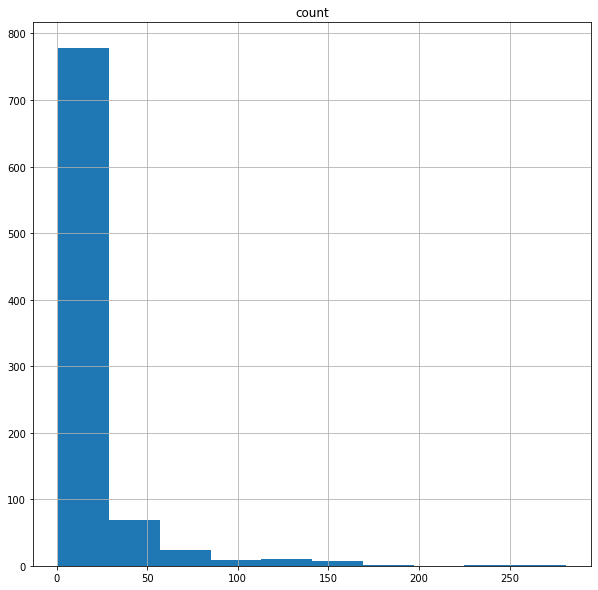

In [ ]:
insert_df.hist(figsize=(10,10))

In [ ]:
|files = ['/content/commonvoice/test/wav/common_voice_ru_20111336.wav', '/content/commonvoice/test/wav/common_voice_ru_20111336.wav']
print(our_model_cv.transcribe(paths2audio_files=files,
                                 batch_size=4))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['в декабриму предстоем более комплексный пмант реализации проекта в области сохранениям наследия', 'в декабриму предстоем более комплексный пмант реализации проекта в области сохранениям наследия']
